In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def load_and_preprocess_data(tsnr_path, smoothness_path):
    """
    Load and preprocess TSNR and smoothness data
    """
    # Expand user paths
    tsnr_path = os.path.expanduser(tsnr_path)
    smoothness_path = os.path.expanduser(smoothness_path)
    
    # Load TSNR data
    data = pd.read_csv(tsnr_path)
    print("TSNR Data Columns:", list(data.columns))
    
    # Define explicit column mapping for TSNR data
    column_mapping = {
        'Subject': 'sub',
        'ReceiveCoilName': 'coil',
        'AcquisitionType': 'acq',
        'tsnrMedian': 'tsnrMedian'
    }
    
    # Check if required columns exist
    missing_cols = [col for col in column_mapping.keys() if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}. Found columns: {list(data.columns)}")
    
    # Rename columns
    data = data.rename(columns=column_mapping)
    
    # Remove subjects with 'sp'
    data = data[~data['sub'].str.contains('sp', na=False)]
    print("TSNR Data after preprocessing:")
    print(data.head())
    
    # Load smoothness data
    smooth_raw = pd.read_csv(smoothness_path)
    print("Smoothness CSV first few rows:")
    print(smooth_raw.head())
    print("Smoothness CSV columns:", list(smooth_raw.columns))
    
    # Fix column names (assume first column name is a filepath and data is mixed)
    smooth = pd.DataFrame()
    filepath_col = smooth_raw.columns[0]  # e.g., 'sub-10015/.../smoothness-5mm.txt'
    
    # Identify rows that are filepaths vs. values
    smooth['filepath'] = smooth_raw[filepath_col].where(
        smooth_raw[filepath_col].str.contains('sub-', na=False),
        pd.NA
    )
    # Forward-fill filepaths to associate with subsequent value rows
    smooth['filepath'] = smooth['filepath'].ffill()
    
    # Use 'Unnamed: 3' as smoothness values
    smooth['smoothness'] = pd.to_numeric(smooth_raw['Unnamed: 3'], errors='coerce')
    
    # Drop rows where smoothness is NaN (i.e., keep only value rows)
    smooth = smooth.dropna(subset=['smoothness'])
    
    # Extract subject and acquisition from filepath
    smooth['sub'] = smooth['filepath'].str.extract(r'sub-(\d+)')
    smooth['acq'] = smooth['filepath'].str.extract(r'acq-(mb\d+me\d+)')
    
    # Remove 'sp' subjects
    smooth = smooth[~smooth['sub'].str.contains('sp', na=False)]
    
    # Select only needed columns
    smooth = smooth[['sub', 'acq', 'smoothness']]
    print("Smoothness Data after preprocessing:")
    print(smooth.head())
    print("Smoothness Data shape:", smooth.shape)
    
    # Merge data
    data_merged = pd.merge(data, smooth, on=['sub', 'acq'], how='left')
    
    # Add mb and me columns
    data_merged['mb'] = data_merged['acq'].str.extract(r'(mb\d+)')[0]
    data_merged['me'] = data_merged['acq'].str.extract(r'(me\d+)')[0]
    
    # Convert columns to categorical
    categorical_cols = ['coil', 'mb', 'me']
    for col in categorical_cols:
        data_merged[col] = pd.Categorical(data_merged[col])
    
    # Debugging prints
    print("Merged Data Columns:", list(data_merged.columns))
    print("Merged Data Head:")
    print(data_merged.head())
    print("Merged Data Info:")
    print(data_merged.info())
    
    return data_merged

def process_data(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and coil
    """
    # Ensure no NaN values in critical columns
    data = data.dropna(subset=['mb', 'me', 'coil', value_column])
    
    print(f"Data after dropna for {value_column}:")
    print(data.head())
    print(f"Number of rows: {len(data)}")
    
    # Group and calculate mean and count unique subjects
    agg_data = data.groupby(['mb', 'me', 'coil'], observed=True).agg({
        value_column: 'mean',
        'sub': 'nunique'
    }).reset_index()
    
    # Calculate standard error
    std_error = data.groupby(['mb', 'me', 'coil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'coil', 'se']
    
    # Merge means, standard errors, and subject counts
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'coil'])
    result.columns = ['mb', 'me', 'coil', value_column, 'n_subjects', 'se']
    
    print(f"Processed Data for {value_column}:")
    print(result.head())
    print(f"Processed Data Info:")
    print(result.info())
    
    return result

def create_tsnr_smoothness_plots(data_processed, img_type='tsnr', save_files=True):
    """
    Create plots similar to the original Python kernel's bar plots
    """
    plt.rcParams.update({'font.size': 48})  # Reduced from 56
    # Dynamically determine coil types from data
    coil_types = data_processed['coil'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    all_y_values = []
    all_y_errors = []
    
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['coil'] == coil]
        if coil_data.empty:
            print(f"No data for coil {coil}")
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')  # Reduced from 56
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)  # Reduced from 56
        ax.tick_params(axis='both', which='major', labelsize=48)  # Reduced from 56
        
        if i == 0:
            ax.set_ylabel(img_type.upper(), fontsize=48)  # Reduced from 56
        
        n_subjects = int(coil_data['n_subjects'].iloc[0]) if not coil_data['n_subjects'].empty else 0
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')  # Reduced from 56
        
        # Set y-axis to start at 0 and extend to max value plus margin
        y_max = max([v + e for v, e in zip(y_values, y_errors) if v != 0], default=0)
        margin = y_max * 0.1  # 10% margin above max
        ax.set_ylim(0, y_max + margin)
    
    # Move legend outside with smaller font size
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    # Adjust layout to accommodate legend outside
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)  # Make room for legend on the right
    
    if save_files:
        plt.savefig(f'{img_type}_analysis.png', dpi=300, bbox_inches='tight')
    
    return fig

def run_statistical_analysis(data):
    """
    Perform statistical analysis on the data (without Tukey test)
    """
    data_long = data.melt(
        id_vars=['sub', 'coil', 'mb', 'me'], 
        value_vars=['tsnrMedian', 'smoothness'], 
        var_name='metric', 
        value_name='value'
    ).dropna(subset=['value'])
    
    results = {}
    
    for metric in ['tsnrMedian', 'smoothness']:
        df_metric = data_long[data_long['metric'] == metric]
        if df_metric.empty:
            print(f"No valid data for {metric}")
            results[metric] = {'error': 'No valid data'}
            continue
        
        try:
            model = smf.mixedlm("value ~ C(coil) * mb * me", df_metric, groups=df_metric["sub"])
            result = model.fit()
            print(f"\nLinear Mixed Effects Model for {metric}:")
            print(result.summary())
            
            results[metric] = {
                'model_summary': result.summary(),
                'significant_interactions': any(':' in term and result.pvalues[term] < 0.05 
                                              for term in result.pvalues.index)
            }
        
        except Exception as e:
            print(f"Analysis failed for {metric}: {str(e)}")
            results[metric] = {'error': str(e)}
    
    return results

def analyze_multiecho_data(tsnr_path, smoothness_path):
    """
    Main function to perform complete analysis
    """
    # Load and preprocess data
    data_merged = load_and_preprocess_data(tsnr_path, smoothness_path)
    
    # Process TSNR and smoothness data
    tsnr_processed = process_data(data_merged, 'tsnrMedian')
    smoothness_processed = process_data(data_merged, 'smoothness')
    
    # Create plots
    tsnr_plot = create_tsnr_smoothness_plots(tsnr_processed, 'tsnrMedian')
    smoothness_plot = create_tsnr_smoothness_plots(smoothness_processed, 'smoothness')
    
    # Run statistical analysis
    statistical_results = run_statistical_analysis(data_merged)
    
    return {
        'data': data_merged,
        'tsnr_plot': tsnr_plot,
        'smoothness_plot': smoothness_plot,
        'statistical_results': statistical_results
    }

TSNR Data Columns: ['Subject', 'ReceiveCoilName', 'AcquisitionType', 'tsnrMean', 'tsnrMedian']
TSNR Data after preprocessing:
     sub  coil     acq   tsnrMean  tsnrMedian
0  10015    64  mb1me1  52.093262   47.814824
1  10015    64  mb3me1  57.683910   52.642603
2  10015    64  mb6me1  58.677708   53.953856
3  10017    64  mb1me1  39.583363   37.468284
4  10017    64  mb1me4  56.804039   51.711247
Smoothness CSV first few rows:
  sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-0mm.txt  \
0                                           0.957374                                                                         
1  sub-10015/L1_task-sharedreward_model-1_type-ac...                                                                         
2                                           0.955262                                                                         
3  sub-10015/L1_task-sharedreward_model-1_type-ac...           

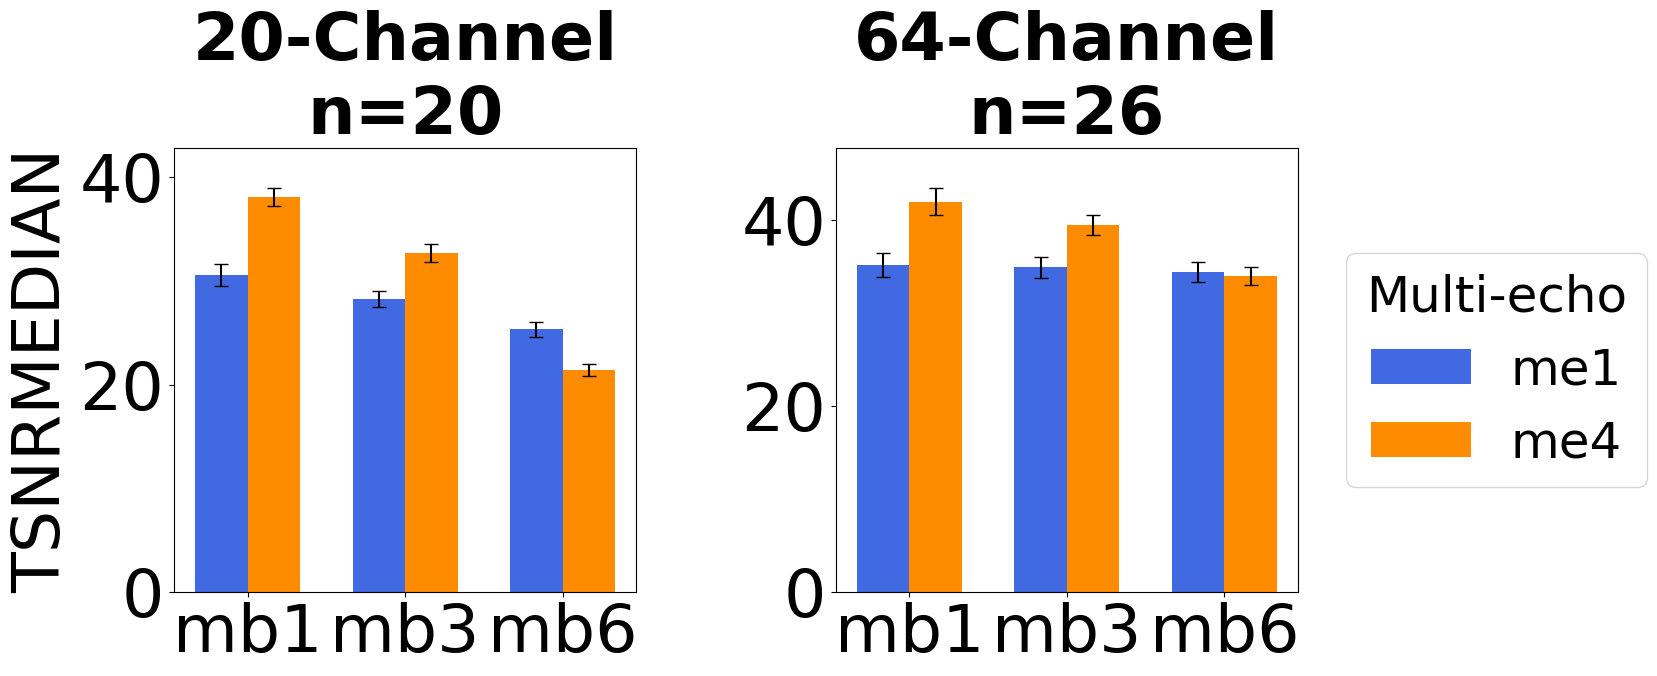

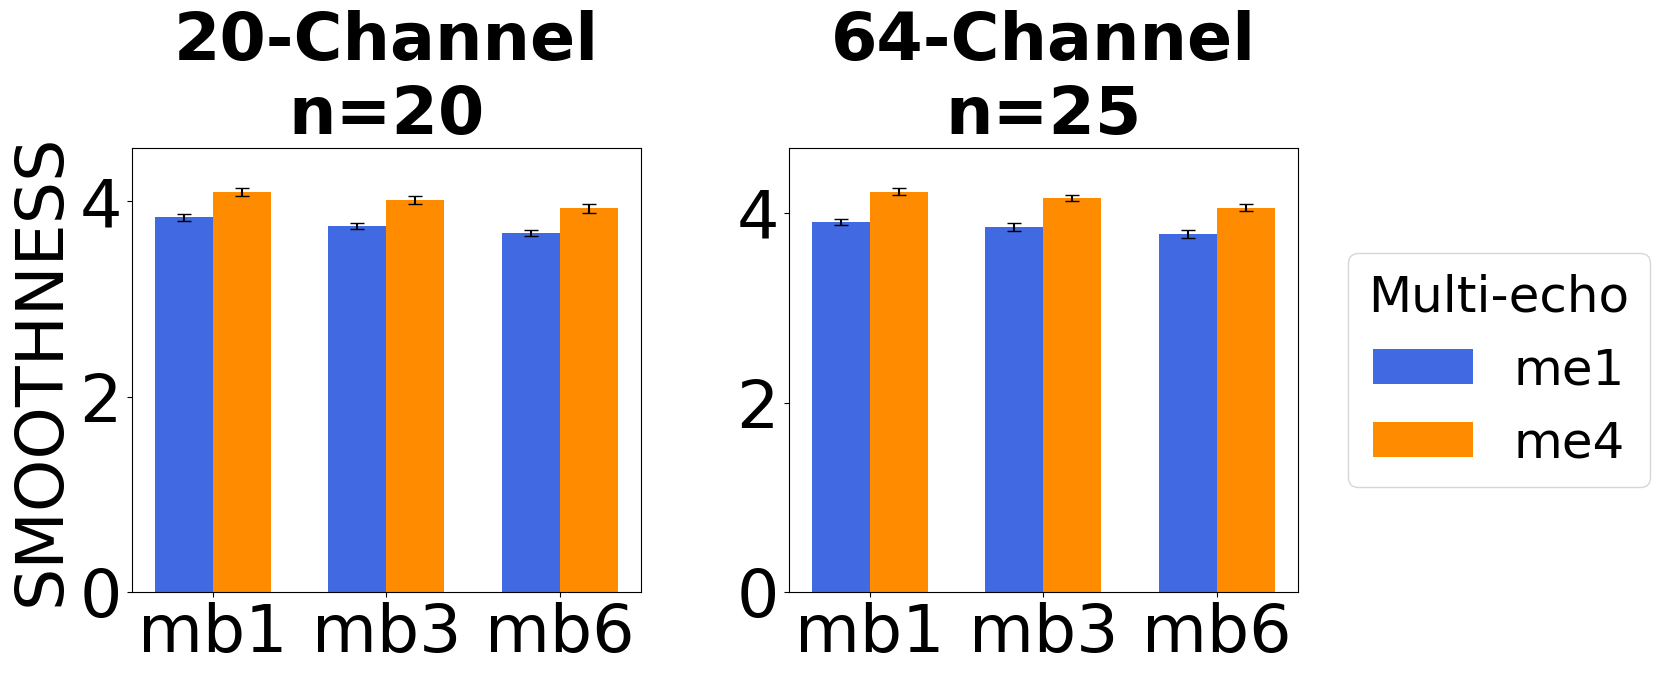

In [3]:
# Example usage
results = analyze_multiecho_data(
    '~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv', 
    '~/Documents/GitHub/multiecho-pilot/smoothness-all-zero.csv'
)

In [6]:
import pandas as pd
print(pd.read_csv('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv').head())

  Subject  ReceiveCoilName AcquisitionType   tsnrMean  tsnrMedian
0   10015               64          mb1me1  52.093262   47.814824
1   10015               64          mb3me1  57.683910   52.642603
2   10015               64          mb6me1  58.677708   53.953856
3   10017               64          mb1me1  39.583363   37.468284
4   10017               64          mb1me4  56.804039   51.711247


In [8]:
smooth = pd.read_csv('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')
print("Smoothness CSV first few rows:")
print(smooth.head())
print("Smoothness CSV columns:", list(smooth.columns))

Smoothness CSV first few rows:
  sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-5mm.txt  \
0                                           0.959011                                                                         
1  sub-10015/L1_task-sharedreward_model-1_type-ac...                                                                         
2                                           0.952358                                                                         
3  sub-10015/L1_task-sharedreward_model-1_type-ac...                                                                         
4                                           0.946439                                                                         

       acq      val  Unnamed: 3  
0  1.99700  18.7472     4.65992  
1      NaN      NaN         NaN  
2  2.09069  20.9349     4.96384  
3      NaN      NaN         NaN  
4  2.08403  20.9583     4.96783  
Smoothne

In [10]:
print("Merged data columns:", list(data_merged.columns))
print("Merged data with coil not null:")
print(data_merged[data_merged['coil'].notna()].head())
print("Merged data shape:", data_merged.shape)

NameError: name 'data_merged' is not defined

In [12]:
# Define functions for generating plots and statistical analysis

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    sns.set_style("whitegrid")
    sns.set_context("talk")
    plt.rcParams.update({'font.size': 56})

def determine_contrast(mask_value):
    """Determine contrast based on mask value"""
    if mask_value in ["VSconstrained", "VMPFC"]:
        return "Rew>Pun"
    elif mask_value == "rFFA":
        return "Str>Com"
    elif mask_value in ["bilateralMotor", "bilateralCerebellum"]:
        return "Avg (L>R, R>L)"
    else:
        return "Unknown"

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    df['headcoil'] = df['headcoil'].astype(str)  # Convert headcoil to categorical
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    return df

def prepare_plot_data(df):
    """Prepare data for plotting by calculating means and errors by headcoil type"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    df_20 = df[df['headcoil'] == '20']
    df_64 = df[df['headcoil'] == '64']
    results = {}
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        means = {acq: hc_df[acq].mean() for acq in acq_params}  # NaN-safe by default
        errors = {acq: hc_df[acq].sem() for acq in acq_params}  # NaN-safe by default
        results[hc_name] = {'means': means, 'errors': errors, 'count': len(hc_df)}
    return results

def create_bar_plots(plot_data, mask_value, contrast, is_first=False, is_last=False):
    """Create bar plots for the given data with consistent y-axis limits within each ROI"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [0+width, 1.2+width, 2.4+width]
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    all_y_values = []
    all_y_errors = []
    
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        all_y_values.extend([v for v in y_values if not np.isnan(v)])  # Filter NaNs
        all_y_errors.extend([e for e in y_errors if not np.isnan(e)])  # Filter NaNs
        if i == 0:
            ax.set_ylabel(f"{mask_value}", fontsize=56)
        if is_first:
            ax.set_title(f"{title}\nn={count}", fontsize=56, fontweight='bold')
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=56)
        ax.tick_params(axis='both', which='major', labelsize=56)
        if is_first and i == 1:
            legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=112)
            legend.get_title().set_fontsize(112)
            ax.legend(loc='upper right')
    
    # Set y-limits only if there are valid values
    if all_y_values and all_y_errors:
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        ax1.set_ylim(y_min - margin, y_max + margin)
        ax2.set_ylim(y_min - margin, y_max + margin)
    else:
        print(f"Warning: No valid data for plotting y-limits in {mask_value}")
    
    if is_last:
        fig.text(0.5, -0.05, 'Multiband Factor', ha='center', fontsize=56)
    plt.tight_layout(pad=1.0)
    if is_last:
        plt.subplots_adjust(bottom=0.2)
    return fig

def process_mask(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects, 
                 is_first=False, is_last=False, save_files=True):
    """Process a single mask, create plots, and run statistical analysis with post-hoc tests"""
    contrast = determine_contrast(mask_value)
    print(f"\nProcessing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    print(f"Using contrast: {contrast}")
    
    # Extract data
    data_by_subject = extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value)
    if not data_by_subject:
        print(f"No matching files found for mask: {mask_value}")
        return None
    
    # Create DataFrame
    df = create_dataframe(data_by_subject, headcoil_64_subjects)
    
    if save_files:
        output_file = f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df)} subjects")
    print("\nSample of the data:")
    print(df.head())
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get('64', 0)}")
    print(f"20-channel: {headcoil_counts.get('20', 0)}")
    print(f"Missing values per column:\n{df.isnull().sum()}")  # Added diagnostic
    
    # Reshape data for statistical analysis
    df_long = pd.melt(
        df, 
        id_vars=['subject', 'headcoil'], 
        value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
        var_name='acq', 
        value_name=img_value
    )
    df_long['mb'] = df_long['acq'].str[:3]  # Extract 'mb1', 'mb3', 'mb6'
    df_long['me'] = df_long['acq'].str[3:]  # Extract 'me1', 'me4'
    df_long = df_long.drop(columns=['acq'])
    
    # Run linear mixed-effects model with NaN handling
    print(f"\nRunning statistical analysis for {mask_value}...")
    df_long_clean = df_long.dropna(subset=[img_value])  # Drop NaNs before LMM
    if len(df_long_clean) < 2:  # Minimum observations for LMM
        print(f"Insufficient data for LMM after removing NaNs: {len(df_long_clean)} observations")
        result = None
    else:
        try:
            model = smf.mixedlm(f"{img_value} ~ C(headcoil) * mb * me", df_long_clean, groups=df_long_clean["subject"])
            result = model.fit()
            print(result.summary())
        except Exception as e:
            print(f"LMM failed: {e}")
            print(f"Shape of df_long_clean: {df_long_clean.shape}")
            print(f"Missing values in df_long_clean:\n{df_long_clean.isnull().sum()}")
            result = None
    
    # Post-hoc tests for significant interactions
    if result is not None:
        print(f"\nChecking for significant interactions in {mask_value}...")
        p_values = result.pvalues
        significant_interactions = any(
            ':' in term and p_values[term] < 0.05 
            for term in p_values.index
        )
        
        if significant_interactions:
            print(f"Significant interactions found. Performing post-hoc tests...")
            print(f"Number of observations after removing NaNs: {len(df_long_clean)}")
            df_long_clean['group'] = df_long_clean['headcoil'] + '_' + df_long_clean['mb'] + '_' + df_long_clean['me']
            print(f"Unique groups: {df_long_clean['group'].unique()}")
            
            try:
                tukey = pairwise_tukeyhsd(endog=df_long_clean[img_value], groups=df_long_clean['group'], alpha=0.05)
                print(tukey)
            except Exception as e:
                print(f"Post-hoc test failed: {e}")
        else:
            print("No significant interactions found. Skipping post-hoc tests.")
    else:
        print("Skipping post-hoc tests due to LMM failure or insufficient data.")
    
    # Prepare plot data and create plots regardless of LMM success
    plot_data = prepare_plot_data(df)
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data, mask_value, contrast, is_first, is_last)
    
    if save_files:
        plot_file = f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig,
        'contrast': contrast,
        'plot_data': plot_data,
        'lmm_result': result  # Added for debugging
    }

def run_analysis(type_value, img_value, mask_values, denoise_value, base_dir=None, save_files=True):
    """Run the full analysis for the given parameters"""
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    headcoil_64_subjects = [
        "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
        "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
        "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
        "10186", "10188", "10221"
    ]
    initialize_plotting_engine()
    print(f"\nAnalysis Parameters: TYPE_VALUE={type_value.upper()}, IMG_VALUE={img_value.capitalize()}")
    results = {}
    for i, mask_value in enumerate(mask_values):
        is_first = (i == 0)
        is_last = (i == len(mask_values) - 1)
        result = process_mask(
            base_dir=base_dir,
            type_value=type_value,
            img_value=img_value, 
            mask_value=mask_value,
            denoise_value=denoise_value,
            headcoil_64_subjects=headcoil_64_subjects,
            is_first=is_first,
            is_last=is_last,
            save_files=save_files
        )
        if result:
            results[mask_value] = result
    return results


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Tsnr

Processing files with parameters: type=act, img=tsnr, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_act_tsnr_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil     mb1me1     mb3me1     mb6me1     mb1me4     mb3me4  \
15    10017       64  47.441217  48.736170  43.101251  70.091718  58.504754   
16    10024       64  41.595123  53.181006  51.031723  64.281742  60.599686   
7     10035       64  51.308512  46.870595  38.905418  72.807299  63.647671   
22    10041       64  44.525315  38.940282  39.330609  51.993155  45.745058   
0     10043       64  56.283196  52.007653  51.011447  59.484562  54.419625   

       mb6me4  
15  42.642998  
16  45.972115  
7   46.401998  
22  43.801459  
0   41.067986  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
m

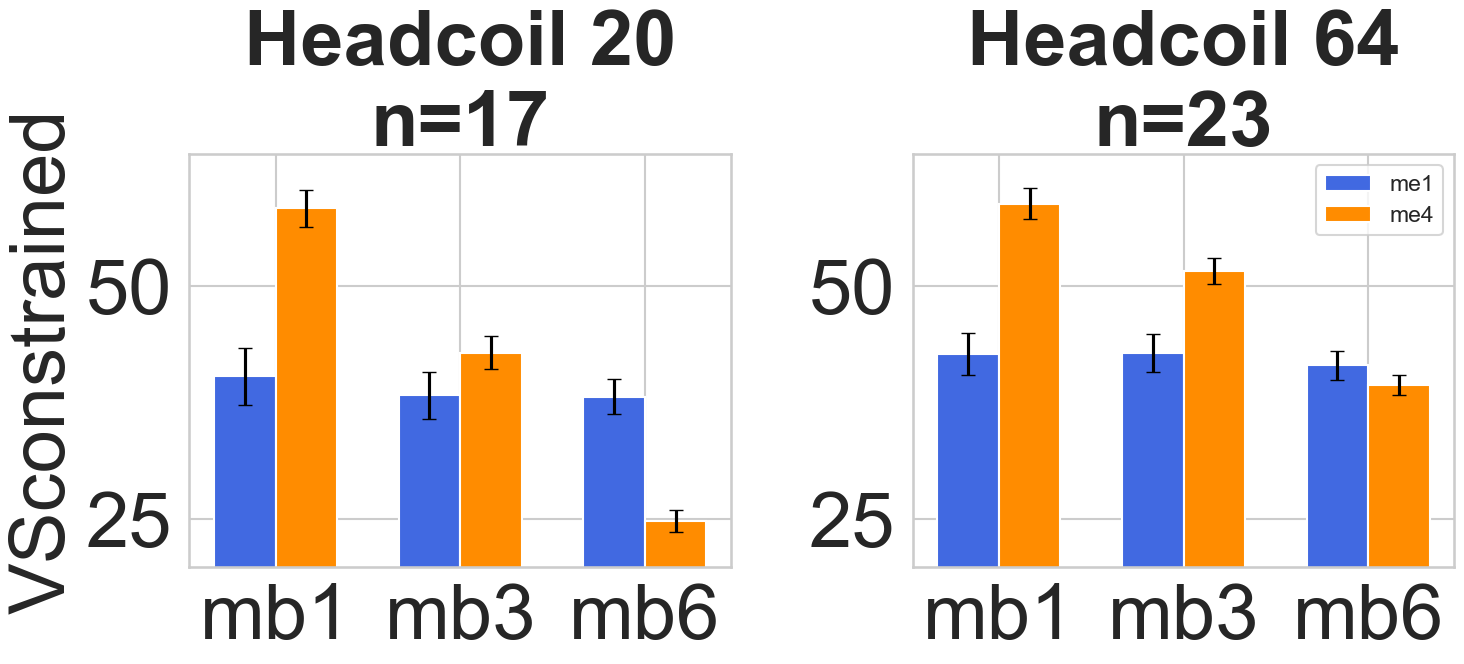

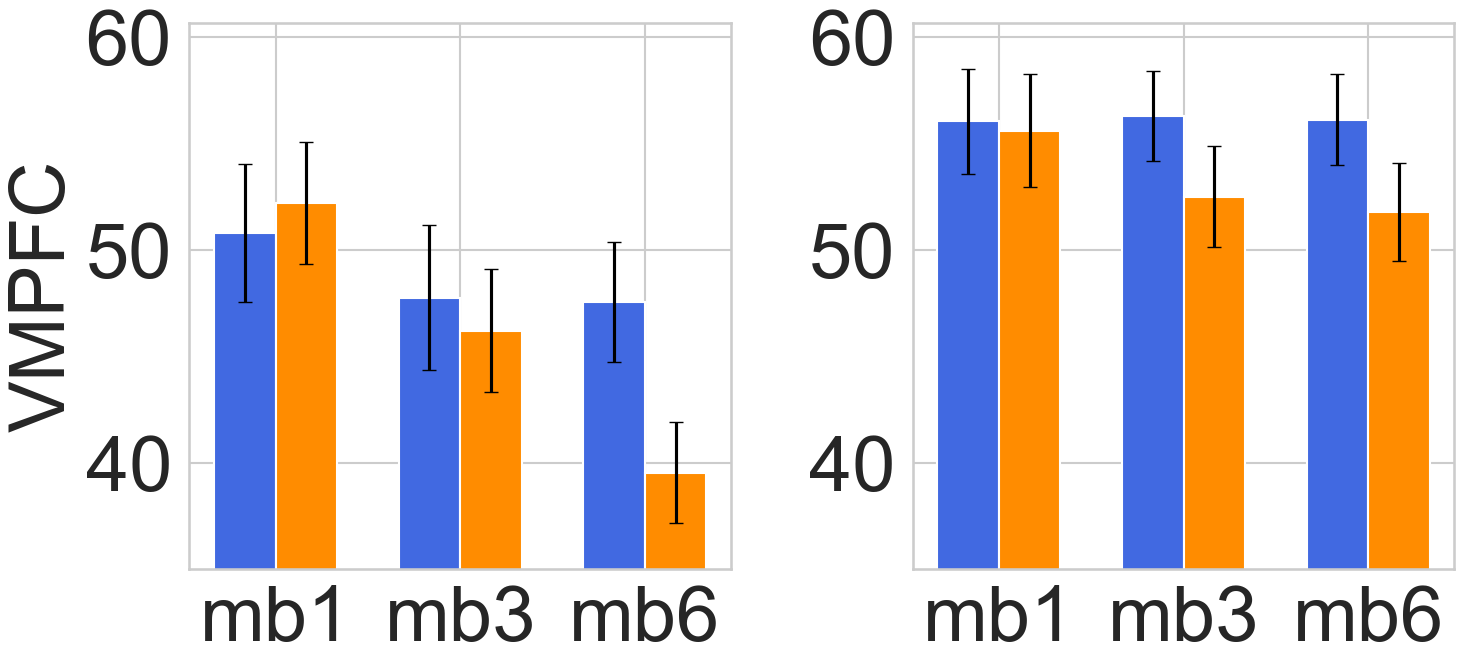

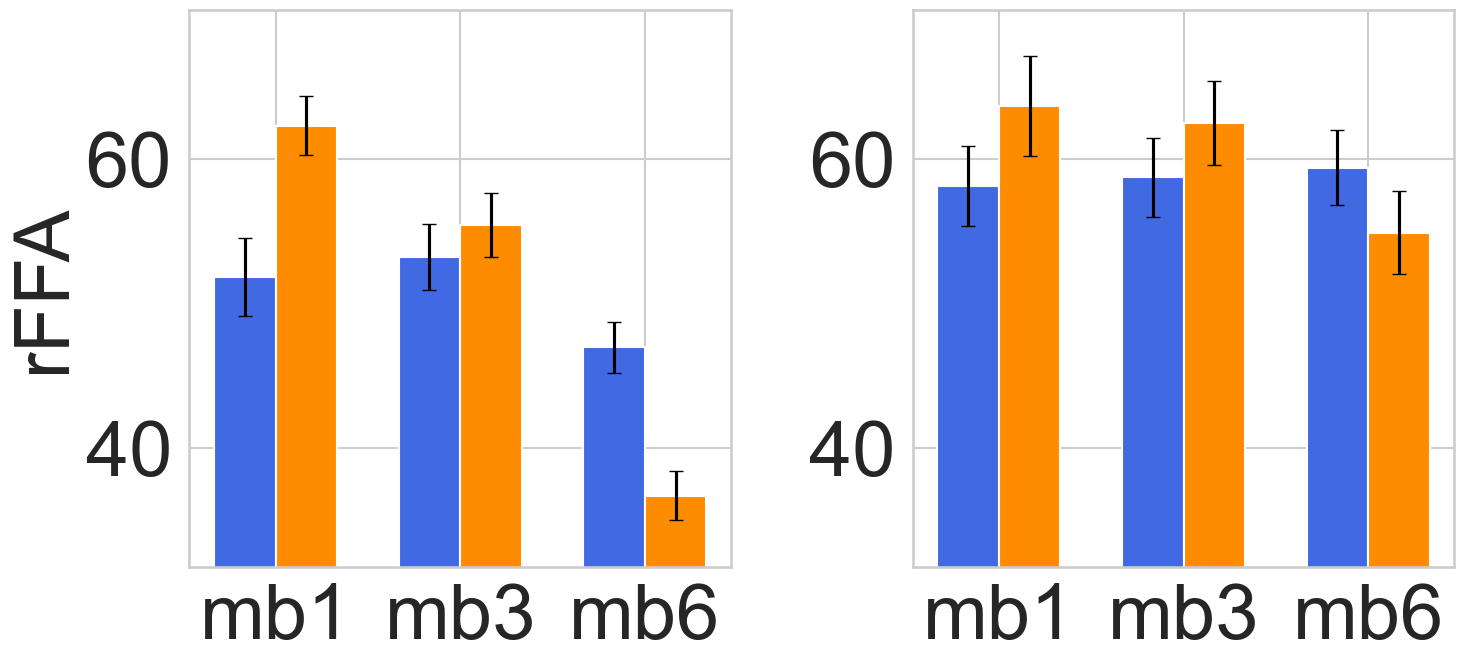

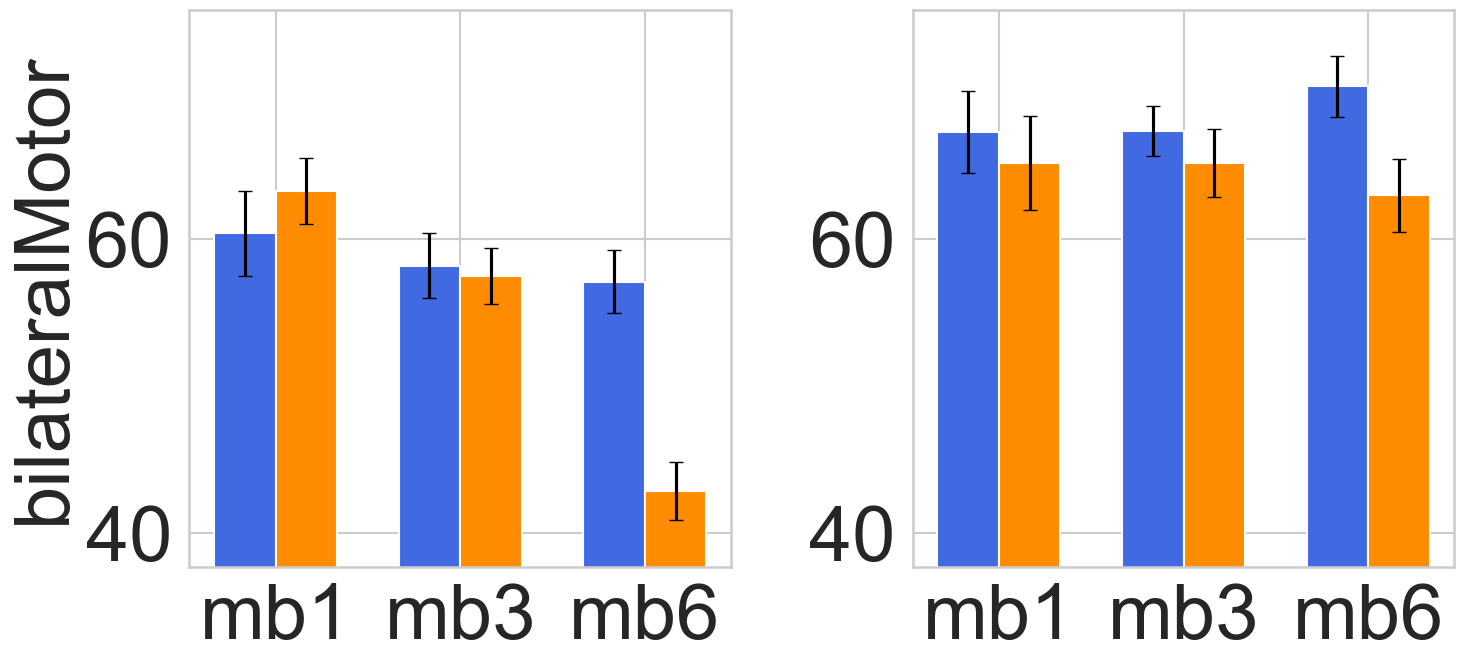

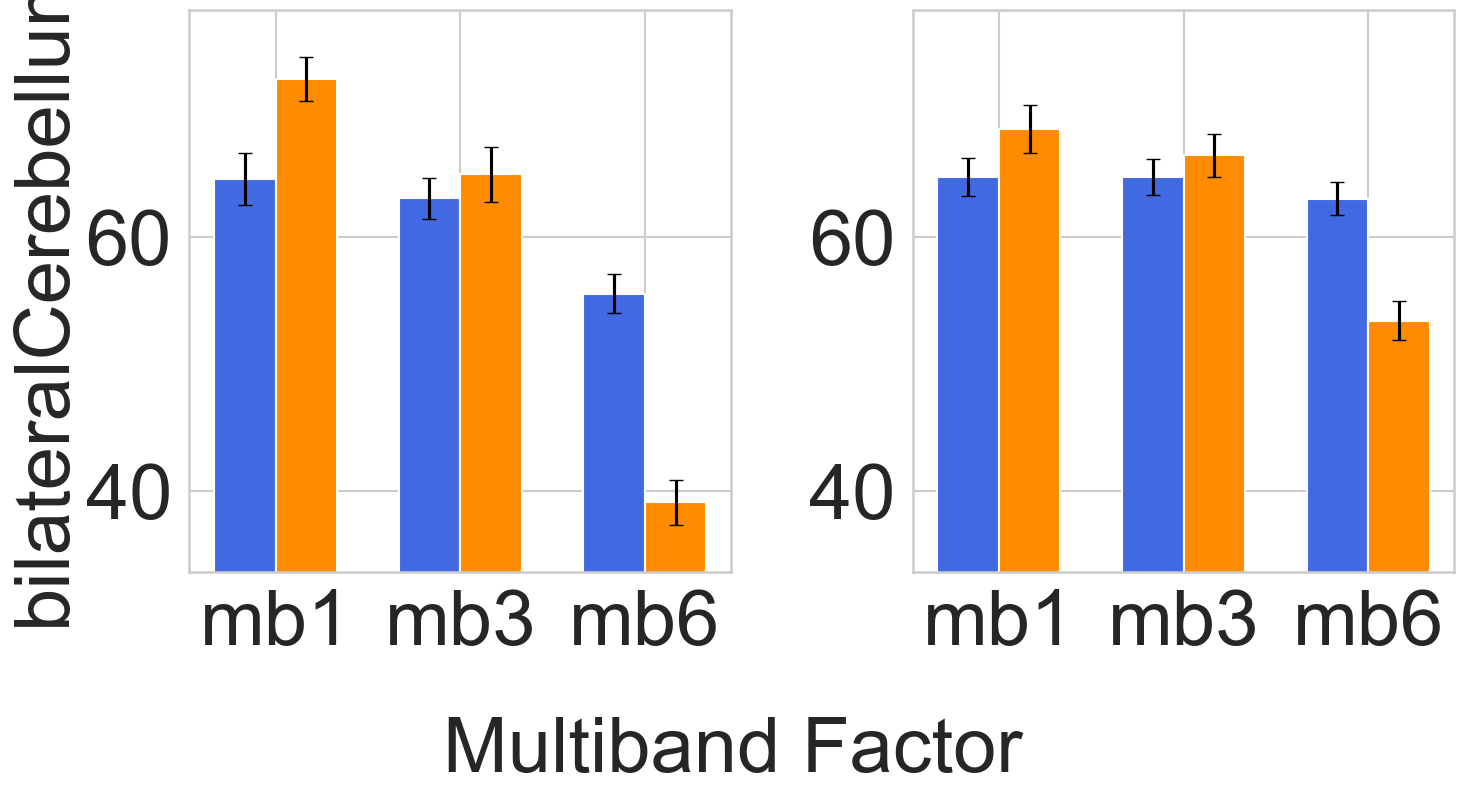

In [14]:
# Figure 5. TSNR by acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "tsnr" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [ ]:
# Figure 6. Beta estimates for activation for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [ ]:
# Supp. Figure 6. zstats for activation for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [ ]:
# Figure 7. Beta estimates for ppi for each acquisition in VMPFC
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VMPFC"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [ ]:
# Supp. Figure 7. zstats for ppi for each acquisition in VMPFC
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VMPFC"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Beta

Processing files with parameters: type=act, img=beta, mask=MEbonf, denoise=base
Using contrast: Unknown
Data saved to multiecho_data_act_beta_MEbonf_base_Unknown.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
11    10017       64    8.150421   67.273194 -124.763834 -259.830598   
26    10024       64  166.896681   57.094650 -114.626654  161.246645   
10    10035       64  -13.534458  -33.523130   60.095114   -4.750628   
37    10041       64   -4.028802   17.994501   77.531756  119.361514   
23    10043       64   -3.860610  167.420097    0.452427    4.826701   

        mb3me4      mb6me4  
11 -178.393018 -682.187231  
26  204.490163   50.525005  
10   88.650153  -41.846154  
37  -44.229357   56.250872  
23   37.368283   -8.232664  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1  

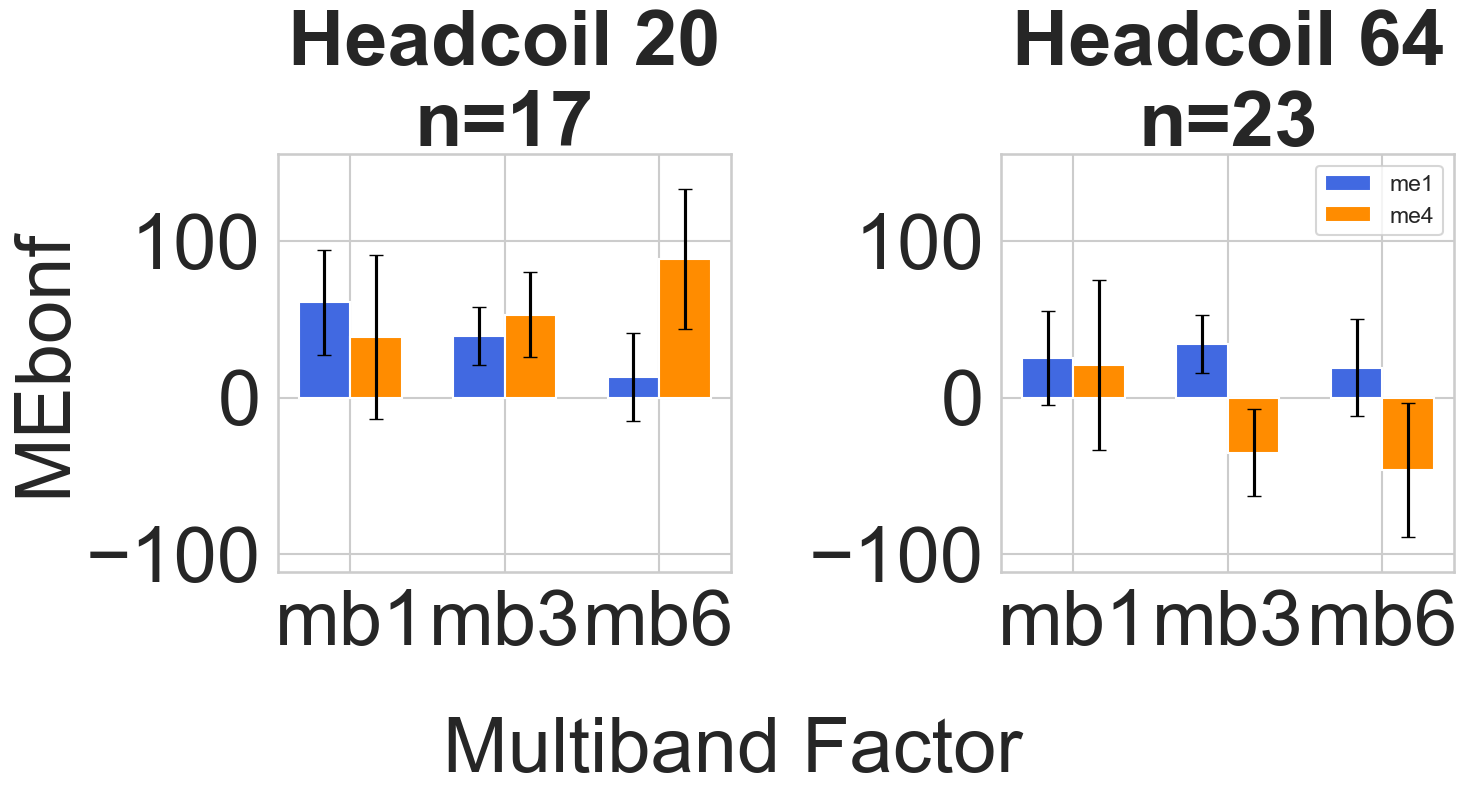

In [22]:
# LME
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["MEbonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Beta

Processing files with parameters: type=act, img=beta, mask=HCxMEbonf, denoise=base
Using contrast: Unknown
Data saved to multiecho_data_act_beta_HCxMEbonf_base_Unknown.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
31    10017       64  295.438841   21.852968 -207.691585 -394.133295   
12    10024       64   76.783216   -9.981706   -4.734478  102.552344   
3     10035       64 -155.581535   75.836538  135.388451   88.176989   
39    10041       64  161.534116 -100.383523 -140.643429  121.807287   
5     10043       64  -57.624064  100.844605   40.871719   59.874133   

        mb3me4      mb6me4  
31  -70.615816 -648.103669  
12   50.987764   68.587415  
3   102.609339  -93.917807  
39    3.241392    4.922172  
5    36.539811  104.554857  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Plot saved as 'multiecho_plots_act_beta_HCxMEbonf_base_Unknown.png'


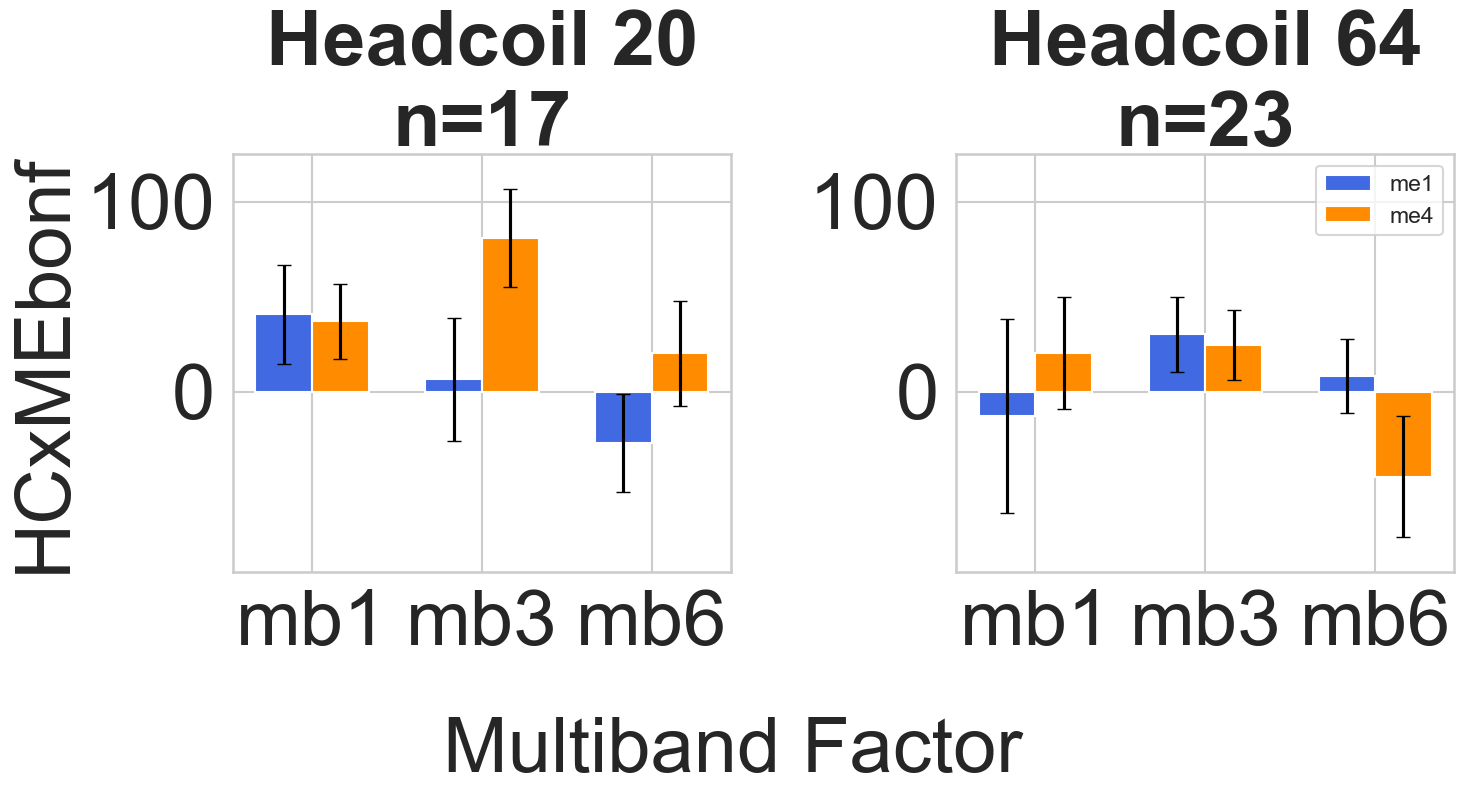

In [24]:
# LME
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["HCxMEbonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Beta

Processing files with parameters: type=act, img=beta, mask=3waybonf, denoise=base
Using contrast: Unknown
Data saved to multiecho_data_act_beta_3waybonf_base_Unknown.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
19    10017       64 -381.339265  358.654660  124.015533 -363.893334   
9     10024       64   95.374408  173.846121   42.953902  315.520862   
37    10035       64  -46.668612 -282.378026  390.689972 -293.295765   
30    10041       64  -97.379226 -183.384727 -592.247797  541.612035   
25    10043       64  545.485084  339.366584  691.537684 -547.773665   

        mb3me4      mb6me4  
19 -324.316170 -764.297090  
9   344.368468  168.902109  
37 -193.739604  229.356091  
30 -150.789050   54.072370  
25   81.010314  -28.180191  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3m

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti

                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           beta      
No. Observations:           240               Method:                       REML      
No. Groups:                 40                Scale:                        80213.9063
Min. group size:            6                 Log-Likelihood:               -1643.5719
Max. group size:            6                 Converged:                    No        
Mean group size:            6.0                                                       
--------------------------------------------------------------------------------------
                                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------------
Intercept                                57.622   75.143  0.767 0.443  -89.656 204.900
C(headcoil)[T.64]                       -21.013   99.096 -0.212 0.83

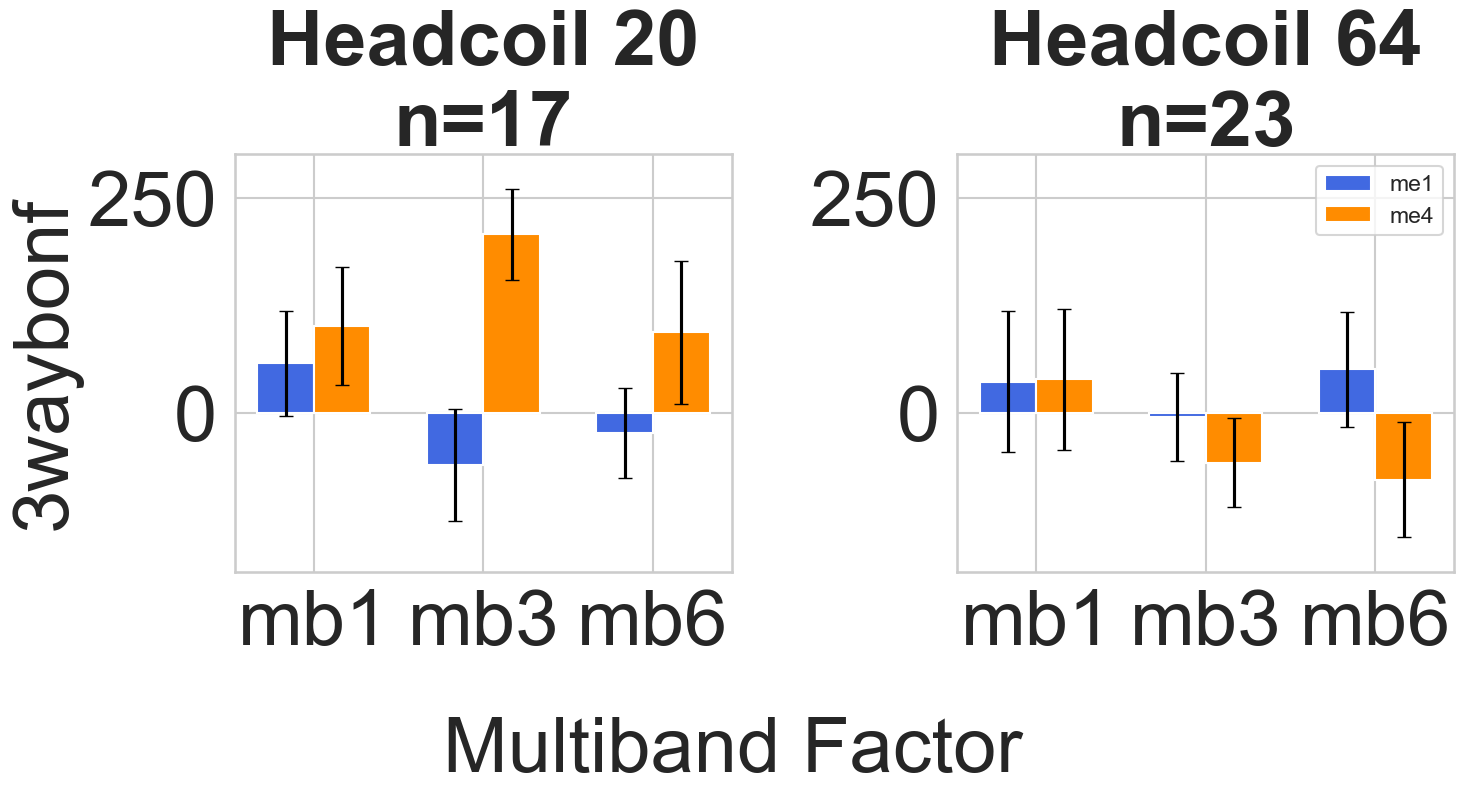

In [26]:
# LME
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["3waybonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [ ]:
# Figure 8 Part 1, Generate avg fd_mean values for each ME acq
import pandas as pd

# Define file paths
input_file = "~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv"
output_file = "~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv"

# Load the TSV file
df = pd.read_csv(input_file, sep="\t")

# Filter out subjects ending in 'sp' and acquisitions containing 'me1'
df = df[~df['Sub'].str.endswith('sp')]
df = df[~df['acq'].str.contains('me1', na=False)]

# Save the filtered DataFrame to a CSV file
df.to_csv(output_file, index=False)

#print("Filtered data saved to:", output_file)

import pandas as pd

# Load your spreadsheet data
df = pd.read_csv(output_file)

# Extract the base 'acq' substring (e.g., mb1me4, mb3me4, mb6me4) from the 'acq' column
df['acq_base'] = df['acq'].str.extract(r'(mb\dme4)')

# Group by 'Sub' and 'acq_base' and calculate the average of 'fd_mean' for each group
averages = df.groupby(['Sub', 'acq_base'])['fd_mean'].mean().reset_index()

# Save the results to a new spreadsheet
output_file_path = 'fd_mean_averages.xlsx'  # Replace with your desired output file path
averages.to_excel(output_file_path, index=False)

# Optionally, print the averages to verify
print(averages)


In [ ]:
# Figure 8 part 2, define function for Figure 8 plots

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")
    # Significantly increase font size
    plt.rcParams.update({'font.size': 56})

def extract_file_data_with_difference(base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params):
    """Extract data and calculate differences between denoise methods for given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    print(f"Found {len(file_paths)} files in {base_dir}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in acq_params:
                continue
            if (file_type == type_value and img == img_value and mask == mask_value and 
                denoise in [denoise_tedana, denoise_base]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in acq_params}
                            for denoise in [denoise_tedana, denoise_base]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in acq_params:
            tedana_val = data[denoise_tedana].get(acq, np.nan)
            base_val = data[denoise_base].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects):
    """Create and merge DataFrame with framewise displacement data"""
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject', 'headcoil'], value_vars=acq_params, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(fd_csv_path)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me\d)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base):
    """Create two batches of scatter plots:
       1. Split by headcoil (red for 20, green for 64)
       2. No split by headcoil (blue dots)
    """
    fig, axes = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)

    # Colors for headcoil scatter plots
    colors = {20: 'red', 64: 'green'}
    legend_handles = []

    for i, acq in enumerate(acq_params):
        ax = axes[i]
        acq_data = df[df['acq'] == acq]

        # Scatter plot with headcoil split
        scatter = sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            hue='headcoil', palette=colors, ax=ax, s=300  # Larger dots
        )

        # Capture legend handles for later use
        if i == 0:
            legend_handles = scatter.legend_.legendHandles

        # Regression lines for each headcoil
        for hc in [20, 64]:
            hc_data = acq_data[acq_data['headcoil'] == hc]
            if len(hc_data) > 1:  # Need at least 2 points for regression
                sns.regplot(x='fd_mean', y='tedana_minus_base', data=hc_data,
                            scatter=False, ax=ax, color=colors[hc], line_kws={'linewidth': 3})

        # Set title for each subplot
        ax.set_title(f'{acq}', fontsize=64, fontweight='bold')

        # Only add y-label to the first subplot
        if i == 0:
            ax.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax.set_ylabel('')

        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=56)

        # Remove individual legends
        ax.legend().remove()

        # Remove redundant x-labels (fd_mean under each plot)
        ax.set_xlabel('')

    # Fine-tuned x-axis label position (closer to ticks)
    fig.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)

    # Adjust layout to make space for the legend
    plt.subplots_adjust(right=0.8)

    # Add a single legend outside the plots (with smaller text and simple labels)
    fig.legend(legend_handles, ['20', '64'], title='Headcoil',
               loc='center left', bbox_to_anchor=(1, 0.5), fontsize=28, title_fontsize=28)

    plt.tight_layout()

    # Create second batch of plots (no headcoil split, all dots blue)
    fig2, axes2 = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)

    for i, acq in enumerate(acq_params):
        ax2 = axes2[i]
        acq_data = df[df['acq'] == acq]

        # Scatter plot (all blue)
        sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            color='blue', ax=ax2, s=300
        )

        # Regression line for all data points
        if len(acq_data) > 1:
            sns.regplot(x='fd_mean', y='tedana_minus_base', data=acq_data,
                        scatter=False, ax=ax2, color='blue', line_kws={'linewidth': 3})

        ax2.set_title(f'{acq}', fontsize=64, fontweight='bold')

        # Only add y-label to the first subplot
        if i == 0:
            ax2.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax2.set_ylabel('')

        ax2.tick_params(axis='both', which='major', labelsize=56)

        # Remove redundant x-labels
        ax2.set_xlabel('')

    # Fine-tuned x-axis label for second batch
    fig2.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)

    plt.tight_layout()

    return fig, fig2


def process_and_visualize_tedana_difference(type_value, img_value, mask_value, denoise_tedana, denoise_base, 
                                           base_dir=None, fd_csv_path=None, acq_params=None, 
                                           headcoil_64_subjects=None, save_files=True):
    """Run the full analysis for tedana-base difference visualization"""
    # Define default values if not provided
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    
    if fd_csv_path is None:
        fd_csv_path = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    
    if acq_params is None:
        acq_params = ["mb1me4", "mb3me4", "mb6me4"]
    
    if headcoil_64_subjects is None:
        headcoil_64_subjects = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
            "10186", "10188", "10221"
        ]
    
    # Initialize plotting environment
    initialize_plotting_engine()
    
    print(f"\nProcessing files for tedana - base difference: type={type_value}, img={img_value}, mask={mask_value}")
    
    # Extract data and calculate differences
    diff_by_subject = extract_file_data_with_difference(
        base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params
    )
    
    if not diff_by_subject:
        print("No matching files found.")
        return None
    
    # Create and merge DataFrame with FD data
    df = create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects)
    
    if save_files:
        # Save to CSV
        output_file = f"multiecho_tedana_minus_base_{type_value}_{img_value}_{mask_value}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df['subject'].unique())} subjects")
    
    # Display the first few rows
    print("\nSample of the merged data:")
    print(df.head())
    
    # Create scatter plots
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base)
    
    if save_files:
        # Save the plot
        plot_file = f"tedana_minus_base_scatter_{type_value}_{img_value}_{mask_value}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig
    }


In [ ]:
# Figure 8. VSconstrained
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "VSconstrained"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. VMPFC
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "VMPFC"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. rFFA
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "rFFA"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. bilateralMotor
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "bilateralMotor"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. bilateralCerebellum
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "bilateralCerebellum"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Define functions for Figure 9

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Extracts numerical data from text files matching specified parameters.
    
    Parameters:
    - base_dir: Path to the directory containing text files.
    - acq_params: List of acquisition parameters to include.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria for filenames.
    
    Returns:
    - data_by_subject: Dictionary with subjects as keys and acquisition data as values.
    """
    pattern = re.compile(
        r"ts_sub-(\d+[a-zA-Z]*)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )

    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    matched_files = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' not in sub_id:
                continue
            if (file_type.lower() == type_value.lower() and 
                img.lower() == img_value.lower() and 
                mask.lower() == mask_value.lower() and 
                denoise.lower() == denoise_value.lower() and 
                acq in acq_params):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                    matched_files += 1
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")

    print(f"Total matched files: {matched_files}")
    return data_by_subject

def create_dataframe(data_by_subject, acq_params):
    """
    Converts extracted data into a structured DataFrame.

    Parameters:
    - data_by_subject: Dictionary with extracted numerical values.
    - acq_params: List of acquisition parameters (column order).
    
    Returns:
    - df: DataFrame with subject IDs and extracted values.
    """
    df = pd.DataFrame.from_dict(data_by_subject, orient='index').reset_index()
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    column_order = ['subject'] + acq_params
    df = df[column_order].sort_values('subject')
    
    return df

def prepare_plot_data(df, acq_params):
    """
    Computes means and standard errors for each acquisition parameter.

    Parameters:
    - df: DataFrame containing extracted values.
    - acq_params: List of acquisition parameters.

    Returns:
    - results: Dictionary with mean values, errors, and subject count.
    """
    means = {acq: df[acq].mean() for acq in acq_params}
    errors = {acq: df[acq].sem() for acq in acq_params}
    return {'means': means, 'errors': errors, 'count': len(df)}

def create_bar_plot(plot_data, acq_params, title, y_label):
    """
    Creates a formatted bar plot with error bars.

    Parameters:
    - plot_data: Dictionary with mean values, errors, and subject count.
    - acq_params: List of acquisition parameters.
    - title: Plot title.
    - y_label: Y-axis label.

    Returns:
    - fig: The created matplotlib figure.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.set_context("talk")

    means = [plot_data['means'][acq] for acq in acq_params]
    errors = [plot_data['errors'][acq] for acq in acq_params]
    
    x_positions = np.arange(len(acq_params))
    ax.bar(x_positions, means, color='lavender', yerr=errors, capsize=5, width=0.8)

    ax.set_ylabel(y_label, fontsize=40)
    ax.set_title(title, fontsize=48, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(acq_params, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel('Acquisition', fontsize=40)
    ax.tick_params(axis='both', labelsize=32)

    # Adjust y-axis limits dynamically
    y_min = min([v - e for v, e in zip(means, errors) if not np.isnan(v)])
    y_max = max([v + e for v, e in zip(means, errors) if not np.isnan(v)])
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)

    plt.tight_layout()
    return fig

def process_and_visualize(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Full pipeline to extract, process, and visualize data.

    Parameters:
    - base_dir: Path to data files.
    - acq_params: List of acquisition parameters.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria.

    Returns:
    - df: Processed DataFrame.
    - fig: Generated bar plot figure.
    """
    print(f"Processing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    
    data_by_subject = extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value)
    
    if not data_by_subject:
        print("No matching files found.")
        return pd.DataFrame(columns=['subject'] + acq_params), plt.figure()
    
    df = create_dataframe(data_by_subject, acq_params)
    df.to_csv(f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}.csv", index=False)

    plot_data = prepare_plot_data(df, acq_params)
    fig = create_bar_plot(plot_data, acq_params, f"sp Subjects (n={plot_data['count']})", f'{mask_value}, {img_value}')

    plot_file = f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    return df, fig


In [ ]:
# Figure 9. Beta estimates for activation for each acquisition in VS for ‘SP’ subjects
if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="beta", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )


In [ ]:
# Supp. Figure 9. zstat for activation for each acquisition in VS for ‘SP’ subjects
if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="zstat", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )